In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import edhec_risk_kit as erk

In [3]:
return_m = pd.read_csv("data/Return.csv",
                     header = 0, index_col = 0, parse_dates = True, na_values = -99.99
                     )
return_m.index = pd.to_datetime(return_m.index, format="%Y%m").to_period('M')
return_m.columns = return_m.columns.str.strip()
return_m = return_m[['SP500','MSCI_EM_Return','MSCI_EU_Return','SovDebtReturn','Global_Agg_Return','Gold_Return']]
return_m.head()

,SP500,MSCI_EM_Return,MSCI_EU_Return,SovDebtReturn,Global_Agg_Return,Gold_Return
Date,,,,,,
2011-07,-0.020,-0.004,-0.034,0.018,0.011,0.084
2011-08,-0.054,-0.089,-0.100,0.000,0.012,0.123
2011-09,-0.070,-0.146,-0.110,-0.044,0.006,-0.114
2011-10,0.109,0.132,0.121,0.044,-0.001,0.063
2011-11,-0.002,-0.067,-0.045,-0.009,-0.005,0.013


In [4]:
er = erk.annualize_rets(return_m,12)
cov=return_m.cov()
er

SP500                0.148171
MSCI_EM_Return       0.043252
MSCI_EU_Return       0.055677
SovDebtReturn        0.053898
Global_Agg_Return    0.038509
Gold_Return          0.007973
dtype: float64

In [5]:
cov

,SP500,MSCI_EM_Return,MSCI_EU_Return,SovDebtReturn,Global_Agg_Return,Gold_Return
SP500,0.001534,0.001478,0.001587,0.000511,-0.000005,0.000108
MSCI_EM_Return,0.001478,0.002598,0.001947,0.000813,0.000036,0.000707
MSCI_EU_Return,0.001587,0.001947,0.002273,0.000701,-0.000007,0.000303
SovDebtReturn,0.000511,0.000813,0.000701,0.000535,0.000090,0.000365
Global_Agg_Return,-0.000005,0.000036,-0.000007,0.000090,0.000060,0.000131
Gold_Return,0.000108,0.000707,0.000303,0.000365,0.000131,0.002196


In [6]:
from scipy.optimize import minimize
def msr(riskfree_rate, er, cov):
    """
    RiskFree rate + ER + COV -> W
    """
    n = er.shape[0]
    init_guess = np.repeat (1/n,n)
    bounds = ((0.0, 1.0),)*n
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe_ratio(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratios, given weights
        """
        r = erk.portfolio_return(weights, er)
        vol = erk.portfolio_vol(weights, cov)
        return -(r-riskfree_rate)/vol
    
    results = minimize(neg_sharpe_ratio, init_guess, 
                       args = (riskfree_rate, er,cov,), method="SLSQP",
                       options = {'disp': False},
                       constraints=(weights_sum_to_1),
                       bounds=bounds
                      )
    return results.x

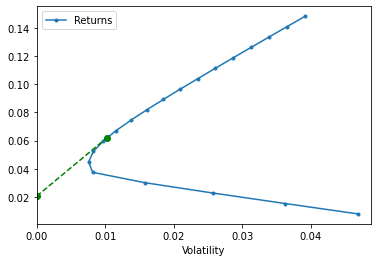

In [7]:
ax = erk.plot_ef(20, er, cov)
ax.set_xlim(left = 0)
rf = 0.0205
w_msr = msr(rf, er, cov)
r_msr = erk.portfolio_return(w_msr, er)
vol_msr = erk.portfolio_vol(w_msr, cov)
# Add CML
cml_x = [0, vol_msr]
cml_y = [rf, r_msr]
ax.plot(cml_x, cml_y, color = "green", marker = "o", linestyle = "dashed")

In [8]:
w_msr

array([2.14598757e-01, 0.00000000e+00, 0.00000000e+00, 1.60172440e-14,
       7.85401243e-01, 7.63390002e-14])

In [10]:
(r_msr-0.0205)/vol_msr

4.040349224255933

In [12]:
r_msr
vol_msr

0.010281783041159832

benchmark_weights = ([0.5,0.5])
benchmark_return = erk.portfolio_return(benchmark_weights, return_m[])
        vol = portfolio_vol(weights, cov)
        return -(r-riskfree_rate)/vol